<a href="https://colab.research.google.com/github/shawngraham/kg/blob/main/autogenerated_knowledge_graph_from_wikipedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

after this: https://towardsdatascience.com/auto-generated-knowledge-graphs-92ca99a81121


In [ ]:
!pip install wikipedia-api
!pip install neuralcoref==4.0

In [3]:
!pip install spacy==2.1.0

     |████████████████████████████████| 27.7MB 137kB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 3.2MB 38.1MB/s 
     |████████████████████████████████| 2.1MB 34.7MB/s 
ERROR: en-core-web-sm 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.0 which is incompatible.
ERROR: en-core-web-lg 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.0 which is incompatible.
  Found existing installation: plac 1.1.3
    Uninstalling plac-1.1.3:
      Successfully uninstalled plac-1.1.3
  Found existing installation: preshed 3.0.5
    Uninstalling preshed-3.0.5:
      Successfully uninstalled preshed-3.0.5
  Found existing installation: blis 0.4.1
    Uninstalling blis-0.4.1:
      Successfully uninstalled blis-0.4.1
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uni

In [6]:
!python -m spacy download en_core_web_lg
# https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab
# then restart the runtime

     |████████████████████████████████| 826.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255077 sha256=f8ec7bde0be6eca5eb6aa2ac8ded5d481958c8f9568da2e1f635d90c29b29700
  Stored in directory: /tmp/pip-ephem-wheel-cache-q4386lwh/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
  Found existing installation: en-core-web-lg 2.2.5
    Uninstalling en-core-web-lg-2.2.5:
      Successfully uninstalled en-core-web-lg-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
import wikipediaapi  
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                return {'page': link, 'text': page.text, 'link': page.fullurl,
                        'categories': list(page.categories.keys())}
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(topic_name))
        return
    
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            sources.append(data) if data else None
            progress.update(1) if verbose else None     
    progress.close() if verbose else None
    
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                  'Template', 'Help', 'User', 'Category talk', 'Portal talk')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(namespaces, na=True))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print('Wikipedia pages scraped:', len(sources))
    
    return sources

the original code below crashed the kernel all the time. i wondered if neuralcoref might be the issue; sure enough, people report kernel crashes, eg https://github.com/huggingface/neuralcoref/issues/207 so i tried installing an earlier version of spacy... and neuralcoref==4.0. Then, there was a missing function in spacy.utils, so I added it below, and pointed the rest of the code to use this function https://stackoverflow.com/questions/62259356/module-spacy-util-has-no-attribute-filter-spans-in-jupyter-notebook

In [7]:
import pandas as pd
import re
import spacy
import neuralcoref

#nlp = spacy.load('en_core_web_lg')

#from spacy.lang.en import English

import en_core_web_lg
nlp = en_core_web_lg.load()


neuralcoref.add_to_pipe(nlp)


def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    # For spaCy 2.1.4+: this function is available as spacy.util.filter_spans()
    get_sort_key = lambda span: (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        # Check for end - 1 here because boundaries are inclusive
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result


def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = filter_spans(spans) 
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

In [8]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(30, 25), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red', font_size=10)
    plt.axis('off')
    plt.show()

In [9]:
# sutton hoo
wiki_data = wiki_scrape('graverobbing')

Links Scraped: 100%|██████████| 79/79 [00:21<00:00,  3.71/s]


Wikipedia pages scraped: 78


In [10]:
display(wiki_data)

,page,text,link,categories,topic
0,graverobbing,"Grave robbery, tomb robbing, or tomb raiding i...",https://en.wikipedia.org/wiki/Grave_robbery,"[All articles with dead external links, All ar...",graverobbing
1,Antiquities trade,The antiquities trade is the exchange of antiq...,https://en.wikipedia.org/wiki/Antiquities_trade,"[All articles needing additional references, A...",graverobbing
2,Antebellum Period,The Antebellum South (also known as the antebe...,https://en.wikipedia.org/wiki/Antebellum_South,"[All articles needing additional references, A...",graverobbing
3,Ancient Egypt,Ancient Egypt was a civilization of ancient No...,https://en.wikipedia.org/wiki/Ancient_Egypt,"[All articles lacking reliable references, All...",graverobbing
4,Abraham Lincoln,"Abraham Lincoln (; February 12, 1809 – April 1...",https://en.wikipedia.org/wiki/Abraham_Lincoln,"[1809 births, 1865 deaths, 1865 murders in the...",graverobbing
...,...,...,...,...,...
75,Category:Articles with unsourced statements fr...,This category combines all articles with unsou...,https://en.wikipedia.org/wiki/Category:Article...,"[Articles with unsourced statements, CatAutoTO...",graverobbing
76,Tutankhamen,"Tutankhamun (, Ancient Egyptian: twt-ꜥnḫ-jmn),...",https://en.wikipedia.org/wiki/Tutankhamun,"[1320s BC deaths, 1340s BC births, 14th-centur...",graverobbing
77,Category:Articles with unsourced statements fr...,This category combines all articles with unsou...,https://en.wikipedia.org/wiki/Category:Article...,"[Articles with unsourced statements, CatAutoTO...",graverobbing
78,Category:Articles with unsourced statements fr...,This category combines all articles with unsou...,https://en.wikipedia.org/wiki/Category:Article...,"[Articles with unsourced statements, CatAutoTO...",graverobbing


...need to lowercase the data. stem it too?


In [17]:
final_data = wiki_data["text"].map(lambda text: text if type(text)!=str else text.lower())

In [18]:
display(final_data)

0     grave robbery, tomb robbing, or tomb raiding i...
1     the antiquities trade is the exchange of antiq...
2     the antebellum south (also known as the antebe...
3     ancient egypt was a civilization of ancient no...
4     abraham lincoln (; february 12, 1809 – april 1...
                            ...                        
75    this category combines all articles with unsou...
76    tutankhamun (, ancient egyptian: twt-ꜥnḫ-jmn),...
77    this category combines all articles with unsou...
78    this category combines all articles with unsou...
79    this category combines all articles with unsou...
Name: text, Length: 78, dtype: object

In [19]:
#pairs = get_entity_pairs(wiki_data.loc[0,'text'])
pairs = get_entity_pairs(final_data.loc[0])

# iterate over everything?

Entity pairs extracted: 10


In [20]:
display(pairs)

,subject,relation,object,subject_type,object_type
0,grave robbers,have,access,NOUN_CHUNK,NOUN_CHUNK
1,robbing,caused,great difficulty,NOUN_CHUNK,NOUN_CHUNK
2,grave robbers,sell,relatively modern items,NOUN_CHUNK,NOUN_CHUNK
3,egyptian pharaohs,kept,records,NOUN_CHUNK,NOUN_CHUNK
4,classical romans,suffered,decades,NOUN_CHUNK,DATE
5,grave robbers,leave,grave robbers,NOUN_CHUNK,NOUN_CHUNK
6,remote undocumented locations,make,remote undocumented locations,NOUN_CHUNK,NOUN_CHUNK
7,buyers,suffer,repercussions,NOUN_CHUNK,NOUN_CHUNK
8,rural location,created,transportation issues,NOUN_CHUNK,NOUN_CHUNK
9,family,had,religious affiliation,NOUN_CHUNK,NOUN_CHUNK


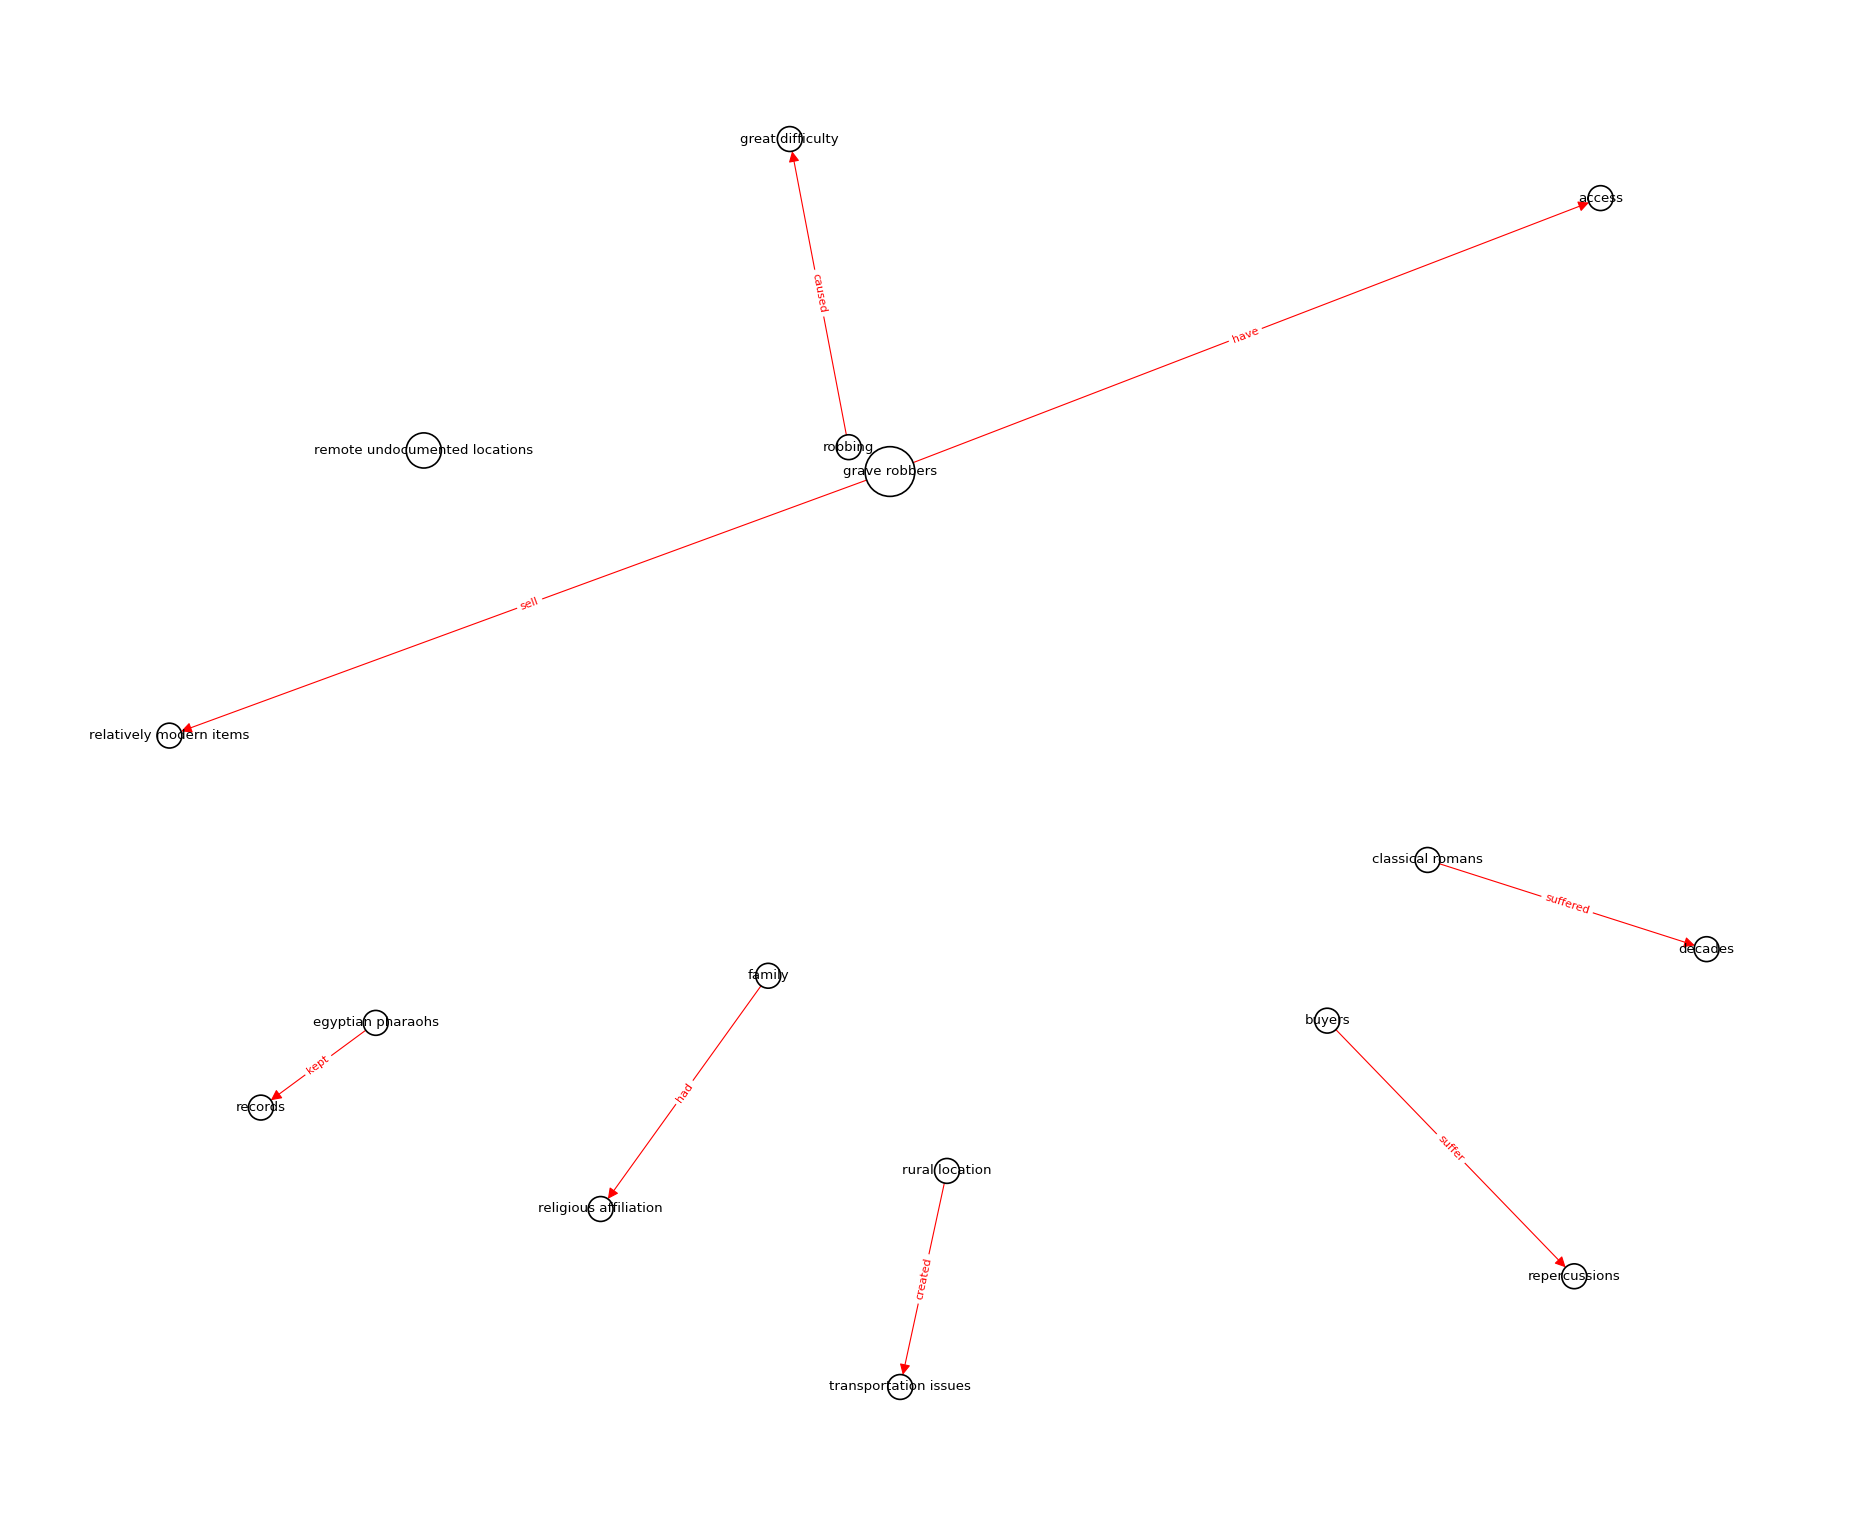

In [21]:
draw_kg(pairs)

# write to graphml?

In [32]:
# export graph to graphml
k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
nx.write_graphml(k_graph, "result.graphml")

# check the graphml file; it seems to give all of the edges the same ID, so that'd have to be corrected brefore importing into gephi


In [23]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

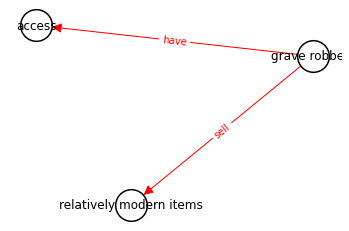

In [24]:
filter_graph(pairs, 'grave robbers')